# Assessing the Impact of Question Ambiguity in Question-Answering Systems

**Objective:** Evaluate how effectively LLMs detect and handle ambiguity in questions and analyze the impact on system performance and output uncertainty.

# STEP 3: Model Evaluation

In [1]:
# Import libraries

!pip install evaluate

import torch, evaluate, pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm import tqdm

import pandas as pd
import evaluate
import string
import torch
import re
import ast
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

2025-09-18 11:19:43.052614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758194383.260642      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758194383.318937      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preprocessing 

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>1. Load the Dataset</b> 
</div>

In [30]:
# load the dataset
df = pd.read_csv('data/final_dataset_annotated_2.csv')
len(df)

1265

In [32]:
df.head()

,title,context,target_word,question,annotated_question,answers,ambiguity_type,answer_annotation
0,Beyoncé,Beyoncé's first solo recording was a feature o...,album,"The album, Dangerously in Love achieved what s...",What spot did the album achieve?,"{'text': ['number four'], 'answer_start': [123]}",lexical,numeric
1,Beyoncé,Following the disbandment of Destiny's Child i...,album,"After her second solo album, what other entert...","After her second album, what other entertainme...","{'text': ['acting'], 'answer_start': [207]}",both,np
2,Beyoncé,Beyoncé's first solo recording was a feature o...,album,Beyonce's first album by herself was called what?,Her first album was called what?,"{'text': ['Dangerously in Love'], 'answer_star...",both,other entity
3,Beyoncé,Beyoncé's first solo recording was a feature o...,album,Beyonce's first solo album in the U.S. with wh...,Her first album in the U.S. featured which art...,"{'text': ['Jay Z'], 'answer_start': [48]}",both,person
4,Beyoncé,"In November 2003, she embarked on the Dangerou...",album,Destiny's Child's final album was named what?,Their final album was named what?,"{'text': ['Destiny Fulfilled'], 'answer_start'...",both,other entity


In [33]:
df.columns

Index(['title', 'context', 'target_word', 'question', 'annotated_question',
       'answers', 'ambiguity_type', 'answer_annotation'],
      dtype='object')

In [34]:
# Remove columns that we do not need during evaluation
df = df.drop(columns=['title','ambiguity_type','answer_annotation'], errors='ignore')

In [35]:
df.columns

Index(['context', 'target_word', 'question', 'annotated_question', 'answers'], dtype='object')

### Dataset Structure before Evaluation

- *'context':* Wikipedia page context
- *'target_word':* ambiguous word
- *'question':* original non-ambiguous question
- *'annotated_question':* annotated ambiguous question
- *'answers':* golden truth answer

In [36]:
df.head()

,context,target_word,question,annotated_question,answers
0,Beyoncé's first solo recording was a feature o...,album,"The album, Dangerously in Love achieved what s...",What spot did the album achieve?,"{'text': ['number four'], 'answer_start': [123]}"
1,Following the disbandment of Destiny's Child i...,album,"After her second solo album, what other entert...","After her second album, what other entertainme...","{'text': ['acting'], 'answer_start': [207]}"
2,Beyoncé's first solo recording was a feature o...,album,Beyonce's first album by herself was called what?,Her first album was called what?,"{'text': ['Dangerously in Love'], 'answer_star..."
3,Beyoncé's first solo recording was a feature o...,album,Beyonce's first solo album in the U.S. with wh...,Her first album in the U.S. featured which art...,"{'text': ['Jay Z'], 'answer_start': [48]}"
4,"In November 2003, she embarked on the Dangerou...",album,Destiny's Child's final album was named what?,Their final album was named what?,"{'text': ['Destiny Fulfilled'], 'answer_start'..."


In [37]:
df.to_csv("data/dataset_for_evaluation_task_3.csv", sep=";", index=False)

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Data Normalization</b> 
</div>

Define functions:
- parse_answer() – parses dictionaries.
- extract_answer_text() – extracts and normalizes the correct answer text.
  
Apply normalization to all relevant text fields: context, question, annotated_question, and answers.

Source for code:

- *[ast.literal_eval](https://docs.python.org/3/library/ast.html#ast.literal_eval)*


In [38]:
def parse_answer(value):
    """Convert stringified dicts into Python dictionaries."""
    if isinstance(value, str) and value.strip().startswith("{") and "'text'" in value:
        try:
            return ast.literal_eval(value)
        except:
            return value  
    return value


def extract_answer_text(x):
    """Extract raw answer text (no normalization), whether it's a dict, string, or number."""
    if isinstance(x, dict) and 'text' in x:
        return str(x['text'])
    elif isinstance(x, (int, float)):
        return str(x)
    elif isinstance(x, str):
        return x
    else:
        return ""


# Parse answers
df['answers'] = df['answers'].apply(parse_answer)

# Extract raw text
df['ground_truth_answer'] = df['answers'].apply(extract_answer_text)

In [39]:
df[['answers', 'ground_truth_answer']].head()

,answers,ground_truth_answer
0,"{'text': ['number four'], 'answer_start': [123]}",['number four']
1,"{'text': ['acting'], 'answer_start': [207]}",['acting']
2,"{'text': ['Dangerously in Love'], 'answer_star...",['Dangerously in Love']
3,"{'text': ['Jay Z'], 'answer_start': [48]}",['Jay Z']
4,"{'text': ['Destiny Fulfilled'], 'answer_start'...",['Destiny Fulfilled']


## Load Model and Tokenizer

- [Pretrained models' parameters](https://huggingface.co/transformers/v2.5.1/pretrained_models.html)

In [40]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import BertTokenizer, BertForQuestionAnswering
from transformers import RobertaTokenizer, RobertaForQuestionAnswering

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>1. Connect to GPU</b> 
</div>

In [41]:
# Connect to GPU (if available)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>2. Define Models and Tokenizers</b> 
</div>

Fine-tuned models' cards on Hugging Face:

- [bert-base-uncased-squad2](https://huggingface.co/twmkn9/bert-base-uncased-squad2)
- [bert-large-uncased-whole-word-masking-finetuned-squad](https://huggingface.co/google-bert/bert-large-uncased-whole-word-masking-finetuned-squad)
- [roberta-base-squad2](https://huggingface.co/deepset/roberta-base-squad2) 
- [roberta-large-squad2](https://huggingface.co/deepset/roberta-large-squad2)
- [deberta-v3-base-squad2](https://huggingface.co/deepset/deberta-v3-base-squad2) 
- [deberta-v3-large-squad2](https://huggingface.co/deepset/deberta-v3-large-squad2)

In [42]:
# BERT
bert_base_tokenizer = AutoTokenizer.from_pretrained("twmkn9/bert-base-uncased-squad2")
bert_base_model = AutoModelForQuestionAnswering.from_pretrained("twmkn9/bert-base-uncased-squad2").to(device)

bert_large_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
bert_large_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad').to(device)


# RoBERTa
roberta_base_tokenizer = RobertaTokenizer.from_pretrained('deepset/roberta-base-squad2')
roberta_base_model = RobertaForQuestionAnswering.from_pretrained('deepset/roberta-base-squad2').to(device)

roberta_large_tokenizer = RobertaTokenizer.from_pretrained('deepset/roberta-large-squad2')
roberta_large_model = RobertaForQuestionAnswering.from_pretrained('deepset/roberta-large-squad2').to(device)


# DeBERTa
deberta_base_tokenizer = AutoTokenizer.from_pretrained("deepset/deberta-v3-base-squad2")
deberta_base_model = AutoModelForQuestionAnswering.from_pretrained("deepset/deberta-v3-base-squad2").to(device)

deberta_large_tokenizer = AutoTokenizer.from_pretrained("deepset/deberta-v3-large-squad2")
deberta_large_model = AutoModelForQuestionAnswering.from_pretrained("deepset/deberta-v3-large-squad2").to(device)


Some weights of the model checkpoint at twmkn9/bert-base-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or

In [43]:
# Define a dictionary
models = {
    "bert-base": (bert_base_tokenizer, bert_base_model),
    "bert-large": (bert_large_tokenizer, bert_large_model),
    "roberta-base": (roberta_base_tokenizer, roberta_base_model),
    "roberta-large": (roberta_large_tokenizer, roberta_large_model),
    "deberta-base": (deberta_base_tokenizer, deberta_base_model),
    "deberta-large": (deberta_large_tokenizer, deberta_large_model)
}

## Answer Prediction

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>1. Answer Prediction</b> 
</div>

Iterates through each row in the dataset. Predicts answers for both the original and ambiguous question. Normalizes predictions and stores them in two new columns: *pred_answer_orig* and *pred_answer_ambig*. 

Source for the [code](https://huggingface.co/transformers/v4.4.2/task_summary.html)

In [44]:
# Predict answers for original and ambiguous questions for all models

# Iterate through models
for model_name, (tokenizer, model) in models.items():
    print(f"\n Predicting answers with: {model_name}...")
    
    model.eval()  # model to evaluation mode

    # Store answers 
    pred_answers_orig = []
    pred_answers_ambig = []

    # Iterate through each row in a dataset
    for _, row in tqdm(df.iterrows(), total=len(df)):
        context = row['context']
        question_orig = row['question']
        question_ambig = row['annotated_question']

        # Encode input  for original question (question and context)
        inputs = tokenizer.encode_plus(
            question_orig,
            context,
            return_tensors='pt',
            truncation=True, # ensures the input not longer that max_length
            max_length=512 # max number of tokents
        )  
        
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            
        # Select start and end position of the prediction
        start = torch.argmax(outputs.start_logits)
        end = torch.argmax(outputs.end_logits) + 1
        answer_orig = tokenizer.convert_tokens_to_string(
            tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][start:end])
        ) 
        pred_answers_orig.append(answer_orig)



        # Predict for ambiguous question
        inputs = tokenizer.encode_plus(
            question_ambig,
            context,
            return_tensors='pt',
            truncation=True,
            max_length=512
        )
        
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            
        start = torch.argmax(outputs.start_logits)
        end = torch.argmax(outputs.end_logits) + 1
        answer_ambig = tokenizer.convert_tokens_to_string(
            tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][start:end])
        )
        pred_answers_ambig.append(answer_ambig)
        

    # Save predictions
    df[f'{model_name}_pred_orig'] = pred_answers_orig
    df[f'{model_name}_pred_ambig'] = pred_answers_ambig


 Predicting answers with: bert-base...


100%|██████████| 1265/1265 [00:29<00:00, 42.18it/s]



 Predicting answers with: bert-large...


  9%|▉         | 113/1265 [00:07<01:09, 16.50it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
100%|██████████| 1265/1265 [01:16<00:00, 16.58it/s]



 Predicting answers with: roberta-base...


  9%|▉         | 114/1265 [00:03<00:29, 39.39it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
100%|██████████| 1265/1265 [00:32<00:00, 39.05it/s]



 Predicting answers with: roberta-large...


  9%|▉         | 114/1265 [00:07<01:07, 17.09it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
100%|██████████| 1265/1265 [01:14<00:00, 16.97it/s]



 Predicting answers with: deberta-base...


100%|██████████| 1265/1265 [01:05<00:00, 19.26it/s]



 Predicting answers with: deberta-large...


100%|██████████| 1265/1265 [02:08<00:00,  9.86it/s]


In [46]:
df.to_csv("data/model_answer_predictions_3.csv", index=False)
df.head()

,context,target_word,question,annotated_question,answers,ground_truth_answer,bert-base_pred_orig,bert-base_pred_ambig,bert-large_pred_orig,bert-large_pred_ambig,roberta-base_pred_orig,roberta-base_pred_ambig,roberta-large_pred_orig,roberta-large_pred_ambig,deberta-base_pred_orig,deberta-base_pred_ambig,deberta-large_pred_orig,deberta-large_pred_ambig
0,Beyoncé's first solo recording was a feature o...,album,"The album, Dangerously in Love achieved what s...",What spot did the album achieve?,"{'text': ['number four'], 'answer_start': [123]}",['number four'],number four,number four,number four,,four,number four,four,atop the Billboard 200,number four,four,four,atop the Billboard 200
1,Following the disbandment of Destiny's Child i...,album,"After her second solo album, what other entert...","After her second album, what other entertainme...","{'text': ['acting'], 'answer_start': [207]}",['acting'],acting,acting,acting,acting,acting,acting,acting,acting,acting,acting,acting,acting
2,Beyoncé's first solo recording was a feature o...,album,Beyonce's first album by herself was called what?,Her first album was called what?,"{'text': ['Dangerously in Love'], 'answer_star...",['Dangerously in Love'],dangerously in love,dangerously in love,dangerously in love,dangerously in love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love
3,Beyoncé's first solo recording was a feature o...,album,Beyonce's first solo album in the U.S. with wh...,Her first album in the U.S. featured which art...,"{'text': ['Jay Z'], 'answer_start': [48]}",['Jay Z'],jay z,jay z,jay z,jay z,Jay Z,"Jay Z's ""'03 Bonnie & Clyde"" that was release...",Jay Z,Jay Z,Jay Z,Jay Z,Jay Z,Jay Z
4,"In November 2003, she embarked on the Dangerou...",album,Destiny's Child's final album was named what?,Their final album was named what?,"{'text': ['Destiny Fulfilled'], 'answer_start'...",['Destiny Fulfilled'],destiny fulfilled,destiny fulfilled,destiny fulfilled,destiny fulfilled,Destiny Fulfilled,Destiny Fulfilled,Destiny Fulfilled,Destiny Fulfilled,Destiny Fulfilled,Destiny Fulfilled,Destiny Fulfilled,Destiny Fulfilled


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>2. Save Answer Predictions fo Target Words used in Error Analysis</b> 
</div>


In [53]:
# Save words for error analysis
words = ["cabinet", "cell", "fan", "season"]

df_words = df[df["target_word"].isin(words)]
df_words.head(3)

,context,target_word,question,annotated_question,answers,ground_truth_answer,bert-base_pred_orig,bert-base_pred_ambig,bert-large_pred_orig,bert-large_pred_ambig,roberta-base_pred_orig,roberta-base_pred_ambig,roberta-large_pred_orig,roberta-large_pred_ambig,deberta-base_pred_orig,deberta-base_pred_ambig,deberta-large_pred_orig,deberta-large_pred_ambig
218,Legislative power lies with the Nitijela. The ...,cabinet,How many ministers are in the Presidential Cab...,How many people are in the cabinet?,"{'text': ['ten'], 'answer_start': [250]}",['ten'],ten,ten,ten,ten,ten,ten,ten,ten,ten,ten,ten,ten
219,"Preceding the reform law, in August 1952, comm...",cabinet,How many posts did the Muslim Brotherhood get ...,How many roles did the group hold in the cabinet?,"{'text': ['two'], 'answer_start': [537]}",['two'],two,four,,two,four,four,two,two,two,two of its members,two,two
220,New Haven is the birthplace of former presiden...,cabinet,"Serving in President Obama's cabinet, this man...","Serving in the cabinet, this individual also s...","{'text': ['John Kerry'], 'answer_start': [419]}",['John Kerry'],john kerry,secretary of state john kerry,john kerry,john kerry,John Kerry,John Kerry,John Kerry,Yale Law School,John Kerry,John Kerry,John Kerry,John Kerry


In [54]:
df_words.tail(3)

,context,target_word,question,annotated_question,answers,ground_truth_answer,bert-base_pred_orig,bert-base_pred_ambig,bert-large_pred_orig,bert-large_pred_ambig,roberta-base_pred_orig,roberta-base_pred_ambig,roberta-large_pred_orig,roberta-large_pred_ambig,deberta-base_pred_orig,deberta-base_pred_ambig,deberta-large_pred_orig,deberta-large_pred_ambig
943,"In season eight, Latin Grammy Award-nominated ...",season,Who was added as a fourth judge in the eighth ...,Who was brought in during the season for a fou...,"{'text': ['Kara DioGuardi'], 'answer_start': [...",['Kara DioGuardi'],kara dioguardi,kara dioguardi,kara dioguardi,kara dioguardi,Kara DioGuardi,Kara DioGuardi,Kara DioGuardi,Kara DioGuardi,Kara DioGuardi,Kara DioGuardi,Kara DioGuardi,Kara DioGuardi
944,The first season was co-hosted by Ryan Seacres...,season,Who was the only host of American Idol after s...,Who hosted the show once season one had passed...,"{'text': ['Ryan Seacrest'], 'answer_start': [34]}",['Ryan Seacrest'],brian dunkleman,brian dunkleman,ryan seacrest,ryan seacrest,Brian Dunkleman,Ryan Seacrest,Ryan Seacrest,Ryan Seacrest,Ryan Seacrest,Ryan Seacrest,Ryan Seacrest,Ryan Seacrest
945,Guest judges may occasionally be introduced. I...,season,Who were the guest judges in season two?,Who joined in as a guest during the second sea...,"{'text': ['Lionel Richie and Robin Gibb'], 'an...",['Lionel Richie and Robin Gibb'],lionel richie and robin gibb,"donna summer, quentin tarantino",lionel richie and robin gibb,lionel richie and robin gibb,Lionel Richie and Robin Gibb,Lionel Richie and Robin Gibb,Lionel Richie and Robin Gibb,Lionel Richie and Robin Gibb,Lionel Richie and Robin Gibb,Lionel Richie and Robin Gibb,Lionel Richie and Robin Gibb,Lionel Richie


In [56]:
df_words.to_csv("data/error_analysis_words_3.csv", index=False)

## Evaluation

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>1. Overall Evaluation</b> 
</div>

Computes Exact Match (EM) and F1 score for both question types using the standard SQuAD metric. Saves the overall results as a DataFrame.

- Source code with SQuAD [metrics](https://huggingface.co/spaces/evaluate-metric/squad_v2)

In [57]:
# Data obtained after answer predictions
df.head(3)

,context,target_word,question,annotated_question,answers,ground_truth_answer,bert-base_pred_orig,bert-base_pred_ambig,bert-large_pred_orig,bert-large_pred_ambig,roberta-base_pred_orig,roberta-base_pred_ambig,roberta-large_pred_orig,roberta-large_pred_ambig,deberta-base_pred_orig,deberta-base_pred_ambig,deberta-large_pred_orig,deberta-large_pred_ambig
0,Beyoncé's first solo recording was a feature o...,album,"The album, Dangerously in Love achieved what s...",What spot did the album achieve?,"{'text': ['number four'], 'answer_start': [123]}",['number four'],number four,number four,number four,,four,number four,four,atop the Billboard 200,number four,four,four,atop the Billboard 200
1,Following the disbandment of Destiny's Child i...,album,"After her second solo album, what other entert...","After her second album, what other entertainme...","{'text': ['acting'], 'answer_start': [207]}",['acting'],acting,acting,acting,acting,acting,acting,acting,acting,acting,acting,acting,acting
2,Beyoncé's first solo recording was a feature o...,album,Beyonce's first album by herself was called what?,Her first album was called what?,"{'text': ['Dangerously in Love'], 'answer_star...",['Dangerously in Love'],dangerously in love,dangerously in love,dangerously in love,dangerously in love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love


In [60]:
# Load the metric
metric = evaluate.load("squad")

# Store the results
overall_results = []

for model_name in models.keys():
    print(f"\nEvaluating {model_name}...")

    # Extract predictions for original and ambiguous questions
    preds_orig = [
        {'id': str(i), 'prediction_text': pred}
        for i, pred in enumerate(df[f"{model_name}_pred_orig"])
    ]
    preds_ambig = [
        {'id': str(i), 'prediction_text': pred}
        for i, pred in enumerate(df[f"{model_name}_pred_ambig"])
    ]

    # Special token count
    def special_token_count(preds):
        """Count how many times special [CLS] token or 'empty' answer was predicted.
        Function returns number of predictions withoug real answer"""
        return sum(
            1 for prediction in preds 
            if str(prediction).strip().lower() in ["", "cls", "[cls]"])

    # Number of predictions in both question types
    cls_count_orig = special_token_count(df[f"{model_name}_pred_orig"])
    cls_count_ambig = special_token_count(df[f"{model_name}_pred_ambig"])

    # Ground truth answer references
    references = [
        {'id': str(i), 'answers': {'text': [ans], 'answer_start': [0]}}
        for i, ans in enumerate(df['ground_truth_answer'])
    ]

    # Compute metrics
    results_orig = metric.compute(predictions=preds_orig, references=references)
    results_ambig = metric.compute(predictions=preds_ambig, references=references)

    # Print results
    print(f"{model_name}:")
    print(f"  Original Question - EM: {results_orig['exact_match']:.2f}, F1: {results_orig['f1']:.2f}")
    print(f"  Ambiguous Question - EM: {results_ambig['exact_match']:.2f}, F1: {results_ambig['f1']:.2f}")
    print(f"  Special token predicted: {cls_count_orig} times (orig), {cls_count_ambig} times (ambig)")

    # Save all results
    overall_results.append({
        "model": model_name,
        "em_orig": results_orig['exact_match'],
        "f1_orig": results_orig['f1'],
        "em_ambig": results_ambig['exact_match'],
        "f1_ambig": results_ambig['f1'],
        "cls_count_orig": cls_count_orig,
        "cls_count_ambig": cls_count_ambig
    })

# Save to file
overall_df = pd.DataFrame(overall_results)
overall_df.to_csv("data/all_models_em_f1_results_3.csv", sep=',', index=False)


Evaluating bert-base...
bert-base:
  Original Question - EM: 83.16, F1: 88.91
  Ambiguous Question - EM: 61.03, F1: 69.11
  Special token predicted: 13 times (orig), 134 times (ambig)

Evaluating bert-large...
bert-large:
  Original Question - EM: 81.34, F1: 88.84
  Ambiguous Question - EM: 66.80, F1: 76.87
  Special token predicted: 5 times (orig), 22 times (ambig)

Evaluating roberta-base...
roberta-base:
  Original Question - EM: 82.21, F1: 90.05
  Ambiguous Question - EM: 61.26, F1: 70.54
  Special token predicted: 10 times (orig), 20 times (ambig)

Evaluating roberta-large...
roberta-large:
  Original Question - EM: 93.60, F1: 96.96
  Ambiguous Question - EM: 64.82, F1: 71.49
  Special token predicted: 4 times (orig), 15 times (ambig)

Evaluating deberta-base...
deberta-base:
  Original Question - EM: 97.47, F1: 98.68
  Ambiguous Question - EM: 68.77, F1: 74.05
  Special token predicted: 4 times (orig), 162 times (ambig)

Evaluating deberta-large...
deberta-large:
  Original Ques

In [59]:
overall_df.columns

Index(['model', 'em_orig', 'f1_orig', 'em_ambig', 'f1_ambig', 'cls_count_orig',
       'cls_count_ambig'],
      dtype='object')

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>2. Evaluation per Target Word</b> 
</div>

Evaluation of models per target word for fine-grained analysis.

In [77]:
metric = evaluate.load("squad")

# Store results per target word
results_per_word = []

# Iterate through target words
for word in df['target_word'].unique():
    df_word = df[df['target_word'] == word]

    # Iterate through models
    for model_name in models: 
        preds_orig = df_word[f"{model_name}_pred_orig"]
        preds_ambig = df_word[f"{model_name}_pred_ambig"]
        answers = df_word['ground_truth_answer']

        # Format predictions and references
        predictions_orig = [{'id': str(i), 'prediction_text': prediction} for i, prediction in enumerate(preds_orig)]
        predictions_ambig = [{'id': str(i), 'prediction_text': prediction} for i, prediction in enumerate(preds_ambig)]
        references = [{'id': str(i), 'answers': {'text': [answer], 'answer_start': [0]}} for i, answer in enumerate(answers)]

        # Count [CLS] or empty predictions
        cls_count_orig = sum(
            1 for prediction
            in preds_orig 
            if str(prediction).strip().lower() in ["", "cls", "[cls]"]
        )
        cls_count_ambig = sum(
            1 for prediction
            in preds_ambig 
            if str(prediction).strip().lower() in ["", "cls", "[cls]"]
        )

        # Evaluation
        results_orig = metric.compute(predictions=predictions_orig, references=references)
        results_ambig = metric.compute(predictions=predictions_ambig, references=references)

        # Save results
        results_per_word.append({
            "target_word": word,
            "model": model_name,
            "em_orig": results_orig['exact_match'],
            "f1_orig": results_orig['f1'],
            "em_ambig": results_ambig['exact_match'],
            "f1_ambig": results_ambig['f1'],
            "cls_count_orig": cls_count_orig,
            "cls_count_ambig": cls_count_ambig
        })

# Convert to DataFrame
df_per_word = pd.DataFrame(results_per_word)
df_per_word.to_csv("data/metrics_per_target_word_3.csv", index=False)
df_per_word

,target_word,model,em_orig,f1_orig,em_ambig,f1_ambig,cls_count_orig,cls_count_ambig
0,album,bert-base,85.0,85.000000,80.0,80.000000,0,0
1,album,bert-large,85.0,85.000000,80.0,80.000000,0,1
2,album,roberta-base,80.0,87.030303,85.0,88.596491,1,1
3,album,roberta-large,95.0,98.333333,95.0,95.000000,0,0
4,album,deberta-base,100.0,100.000000,95.0,98.333333,0,0
...,...,...,...,...,...,...,...,...
379,work,bert-large,70.0,82.000000,65.0,73.500000,1,2
380,work,roberta-base,85.0,87.000000,75.0,79.500000,0,0
381,work,roberta-large,100.0,100.000000,90.0,95.833333,0,0
382,work,deberta-base,100.0,100.000000,75.0,75.102564,0,2



## Plotting the Results

- The results in this section were plotted with the help of 'gpt-4o' model


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>1. Plot overall results per Model</b> 
</div>

In [78]:
# Aggregated results (EM, F1) per model
overall_df

,model,em_orig,f1_orig,em_ambig,f1_ambig,cls_count_orig,cls_count_ambig
0,bert-base,83.162055,88.909852,61.027668,69.107880,13,134
1,bert-large,81.343874,88.841362,66.798419,76.872061,5,22
2,roberta-base,82.213439,90.053486,61.264822,70.539917,10,20
3,roberta-large,93.596838,96.959785,64.822134,71.488967,4,15
4,deberta-base,97.470356,98.675843,68.774704,74.048739,4,162
5,deberta-large,91.225296,96.366815,64.664032,72.073065,4,190


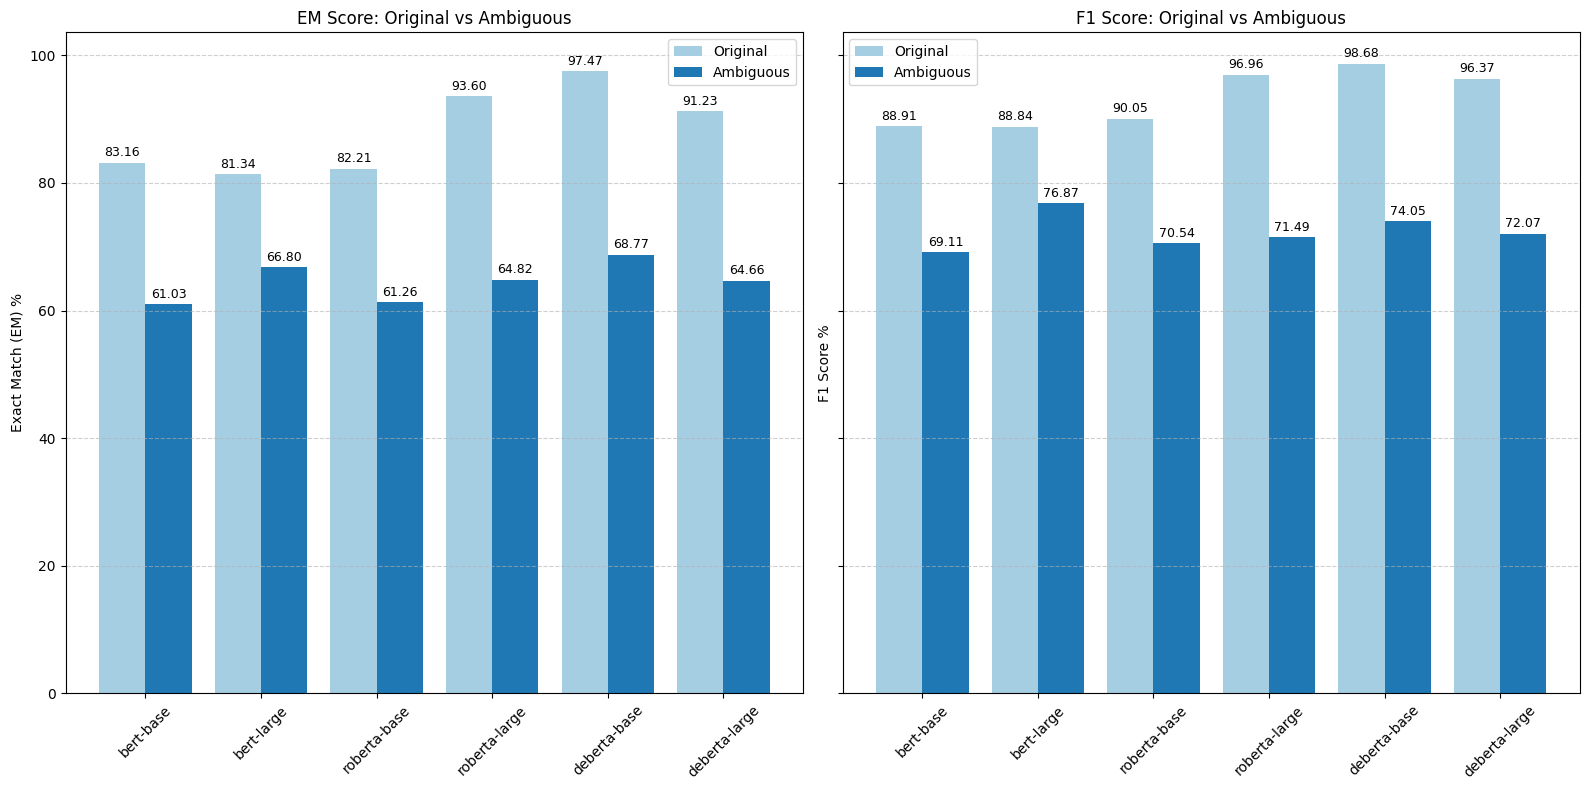

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data
models = overall_df['model'].tolist()
em_orig = overall_df['em_orig'].tolist()
em_ambig = overall_df['em_ambig'].tolist()
f1_orig = overall_df['f1_orig'].tolist()
f1_ambig = overall_df['f1_ambig'].tolist()

# Bar positions
x = np.arange(len(models))
bar_width = 0.40

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot 1: EM Scores
bars_em_orig = axs[0].bar(x - bar_width/2, em_orig, bar_width, label='Original', color='#a6cee3')
bars_em_ambig = axs[0].bar(x + bar_width/2, em_ambig, bar_width, label='Ambiguous', color='#1f78b4')

axs[0].set_title('EM Score: Original vs Ambiguous')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=45)
axs[0].set_ylabel('Exact Match (EM) %')
axs[0].legend()
axs[0].grid(axis='y', linestyle='--', alpha=0.6)

# Add labels 
for i in range(len(models)):
    axs[0].text(x[i] - bar_width/2, em_orig[i] + 1, f"{em_orig[i]:.2f}", ha='center', fontsize=9)
    axs[0].text(x[i] + bar_width/2, em_ambig[i] + 1, f"{em_ambig[i]:.2f}", ha='center', fontsize=9)

# Plot 2: F1 Scores
bars_f1_orig = axs[1].bar(x - bar_width/2, f1_orig, bar_width, label='Original', color='#a6cee3')
bars_f1_ambig = axs[1].bar(x + bar_width/2, f1_ambig, bar_width, label='Ambiguous', color='#1f78b4')

axs[1].set_title('F1 Score: Original vs Ambiguous')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=45)
axs[1].set_ylabel('F1 Score %')
axs[1].legend()
axs[1].grid(axis='y', linestyle='--', alpha=0.6)

# Add labels 
for i in range(len(models)):
    axs[1].text(x[i] - bar_width/2, f1_orig[i] + 1, f"{f1_orig[i]:.2f}", ha='center', fontsize=9)
    axs[1].text(x[i] + bar_width/2, f1_ambig[i] + 1, f"{f1_ambig[i]:.2f}", ha='center', fontsize=9)


plt.tight_layout()

# Save
plt.savefig("figures/em_f1_model_comparison_3.png", dpi=300)

plt.show()

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>2. Plot number of special tokens per Model</b> 
</div>

In [80]:
# Results (EM, F1) per model per target word
df_per_word[10:20]

,target_word,model,em_orig,f1_orig,em_ambig,f1_ambig,cls_count_orig,cls_count_ambig
10,area,deberta-base,95.0,99.444444,65.0,81.702381,0,2
11,area,deberta-large,70.0,92.849206,55.0,77.285714,0,2
12,article,bert-base,80.0,88.666667,70.0,77.833333,0,2
13,article,bert-large,90.0,92.000000,80.0,83.250000,0,0
14,article,roberta-base,80.0,86.666667,70.0,78.690476,0,0
15,article,roberta-large,95.0,98.333333,75.0,80.611111,0,0
16,article,deberta-base,100.0,100.000000,80.0,83.333333,0,0
17,article,deberta-large,95.0,98.333333,80.0,83.111111,0,1
18,ball,bert-base,85.0,87.833333,65.0,67.259740,0,4
19,ball,bert-large,85.0,87.833333,85.0,87.000000,0,0


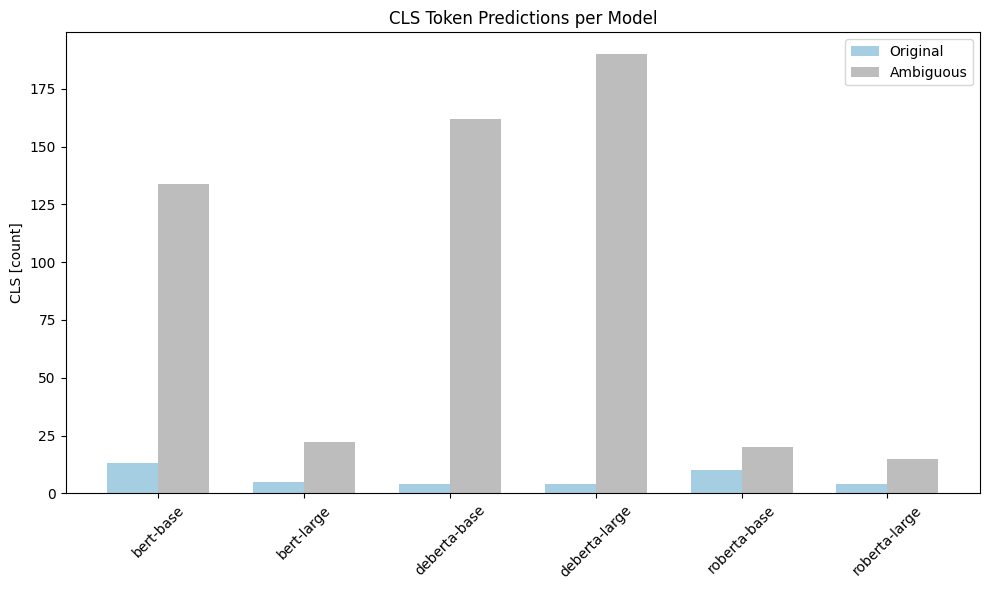

In [81]:
# Aggregate CLS counts by model
cls_per_model = df_per_word.groupby("model").agg({
    "cls_count_orig": "sum",
    "cls_count_ambig": "sum"
}).reset_index()

x = np.arange(len(cls_per_model))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, cls_per_model["cls_count_orig"], width,
        label="Original", color="#a6cee3")
plt.bar(x + width/2, cls_per_model["cls_count_ambig"], width,
        label="Ambiguous", color="#bdbdbd")

plt.xticks(x, cls_per_model["model"], rotation=45)
plt.ylabel("CLS [count]")
plt.title("CLS Token Predictions per Model")
plt.legend()
plt.tight_layout()

plt.savefig("figures/orig_ambig_model_cls_3.png", dpi=300)

plt.show()

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>3. Relation of Question Length to Model Performance</b> 
</div>

- Plot the relation of question length to models' performance (F1 score) to check whether models' performance dependent on question length.
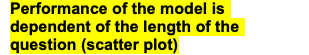
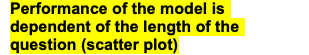
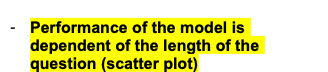
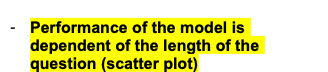

In [82]:
len_per_word = pd.read_csv("data/len_per_word_2.csv")
len_per_word

,target_word,orig_len,ambig_len
0,album,9.800000,8.700000
1,area,11.350000,8.750000
2,article,11.600000,8.700000
3,ball,17.050000,11.450000
4,bank,12.600000,10.750000
...,...,...,...
59,title,10.850000,8.050000
60,track,10.600000,7.450000
61,volume,12.210526,8.315789
62,way,12.950000,8.350000


In [83]:
# Merge datasets with F1 count per word and question length per word
merged = df_per_word.merge(len_per_word, on="target_word", how="left")
merged

,target_word,model,em_orig,f1_orig,em_ambig,f1_ambig,cls_count_orig,cls_count_ambig,orig_len,ambig_len
0,album,bert-base,85.0,85.000000,80.0,80.000000,0,0,9.8,8.7
1,album,bert-large,85.0,85.000000,80.0,80.000000,0,1,9.8,8.7
2,album,roberta-base,80.0,87.030303,85.0,88.596491,1,1,9.8,8.7
3,album,roberta-large,95.0,98.333333,95.0,95.000000,0,0,9.8,8.7
4,album,deberta-base,100.0,100.000000,95.0,98.333333,0,0,9.8,8.7
...,...,...,...,...,...,...,...,...,...,...
379,work,bert-large,70.0,82.000000,65.0,73.500000,1,2,12.1,9.6
380,work,roberta-base,85.0,87.000000,75.0,79.500000,0,0,12.1,9.6
381,work,roberta-large,100.0,100.000000,90.0,95.833333,0,0,12.1,9.6
382,work,deberta-base,100.0,100.000000,75.0,75.102564,0,2,12.1,9.6


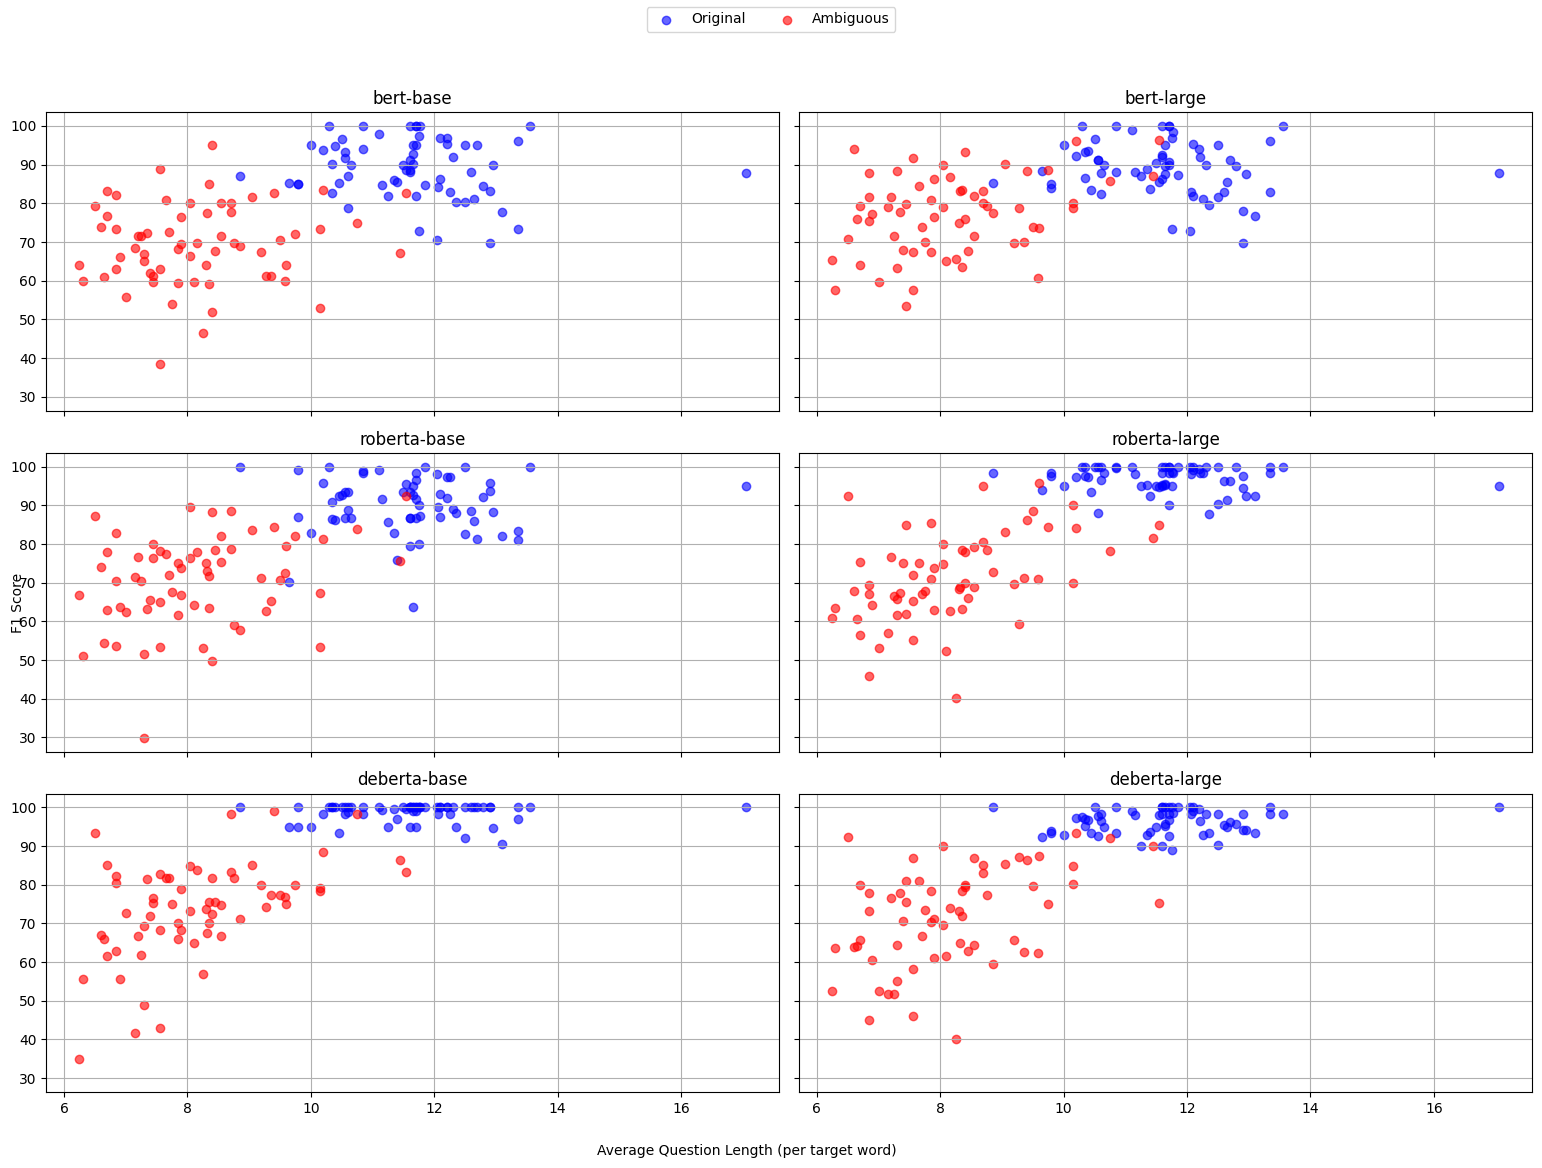

In [84]:
models = ["bert-base", "bert-large",
          "roberta-base", "roberta-large",
          "deberta-base", "deberta-large"]

fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.ravel()

for i, m in enumerate(models):
    ax = axes[i]
    m_df = merged[merged["model"] == m].dropna(subset=["orig_len","ambig_len","f1_orig","f1_ambig"])

    ax.scatter(m_df["orig_len"], m_df["f1_orig"], alpha=0.6, label="Original", color="blue")
    ax.scatter(m_df["ambig_len"], m_df["f1_ambig"], alpha=0.6, label="Ambiguous", color="red")

    ax.set_title(m)
    ax.grid(True)

# Common labels
fig.text(0.5, 0.04, "Average Question Length (per target word)", ha="center")
fig.text(0.04, 0.5, "F1 Score", va="center", rotation="vertical")

# Add one legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)

plt.tight_layout(rect=[0.03, 0.06, 1, 0.94])
  
plt.savefig("figures/orig_ambig_qn_length_model_3.png", dpi=300)  

plt.show()

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>4. Plot a Heatmap</b> 
</div>

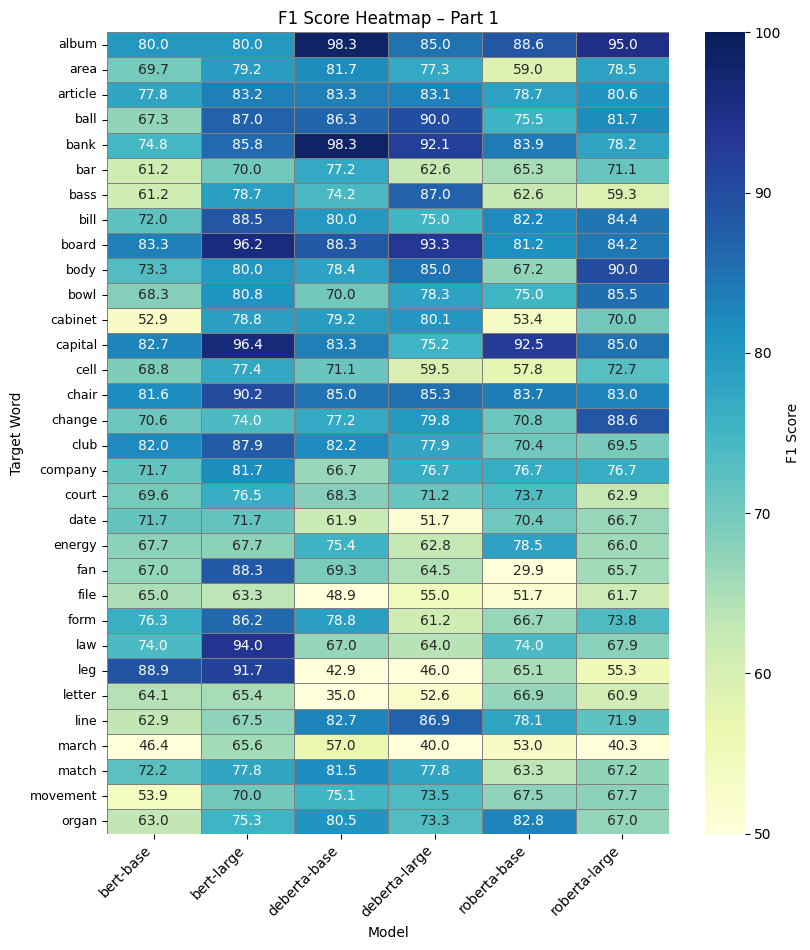

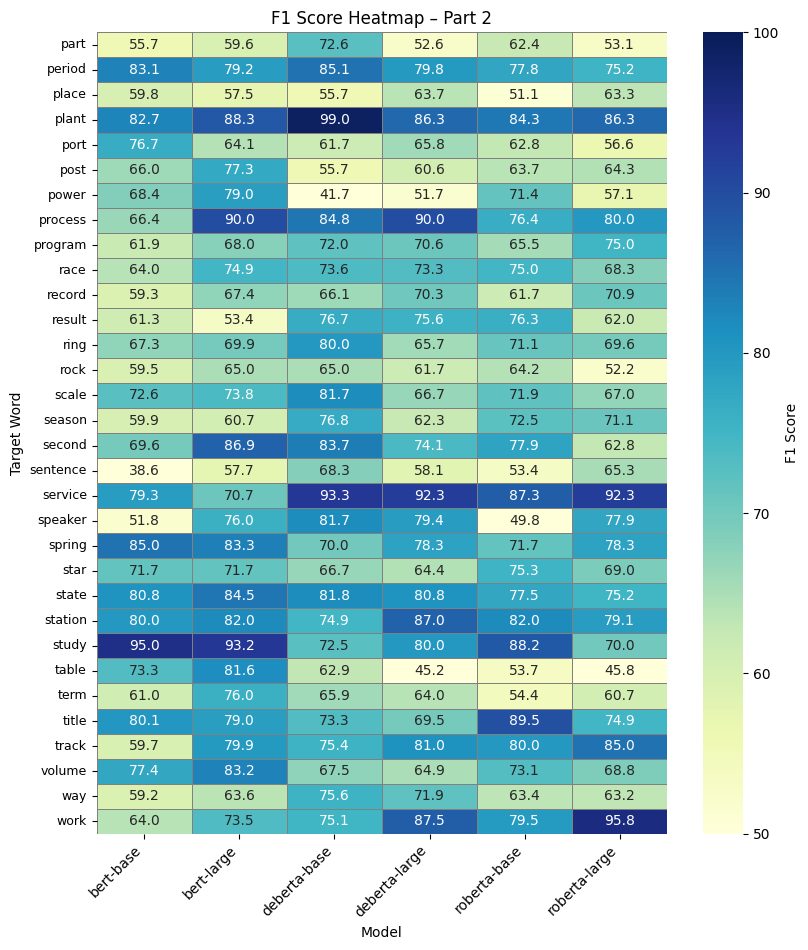

In [90]:
import math

# Group words into chunks
unique_words = sorted(df_per_word['target_word'].unique())
chunks = [unique_words[i:i+32] for i in range(0, len(unique_words), 32)]

for idx, word_chunk in enumerate(chunks):
    pivot_df_chunk = df_per_word[df_per_word['target_word'].isin(word_chunk)].pivot_table(
        index="target_word",
        columns="model",
        values="f1_ambig"
    )

    plt.figure(figsize=(8.3, max(6, len(word_chunk)*0.3)))
    sns.heatmap(
        pivot_df_chunk,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': 'F1 Score'},
        vmin=50, vmax=100
    )

    plt.title(f"F1 Score Heatmap – Part {idx + 1}", fontsize=12)
    plt.xlabel("Model", fontsize=10)
    plt.ylabel("Target Word", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()

    plt.savefig(f"figures/heatmap_f1_part_{idx+1}_3.png", dpi=300)
    
    plt.show()


Top 10 highest mean F1 (orig):
target_word
date       99.791667
study      99.722222
bowl       99.583333
club       99.444444
process    99.444444
law        99.166667
star       98.888889
rock       98.055556
bill       97.861111
chair      97.692766
Name: mean_f1_orig, dtype: float64

Top 10 highest mean F1 (ambig):
target_word
album      87.821637
plant      87.815599
board      87.767742
service    85.880952
capital    85.865090
bank       85.521224
chair      84.796684
study      83.138889
ball       81.291258
process    81.269841
Name: mean_f1_ambig, dtype: float64

Top 10 highest std F1 (orig):
target_word
march       14.354101
result      14.084477
speaker     12.991832
sentence    12.107830
match       11.417618
track        9.319451
fan          9.213125
ring         8.755526
work         8.358905
race         7.866713
Name: std_f1_orig, dtype: float64

Top 10 highest std F1 (ambig):
target_word
leg        21.122030
fan        18.959043
table      14.923461
speaker    14.54

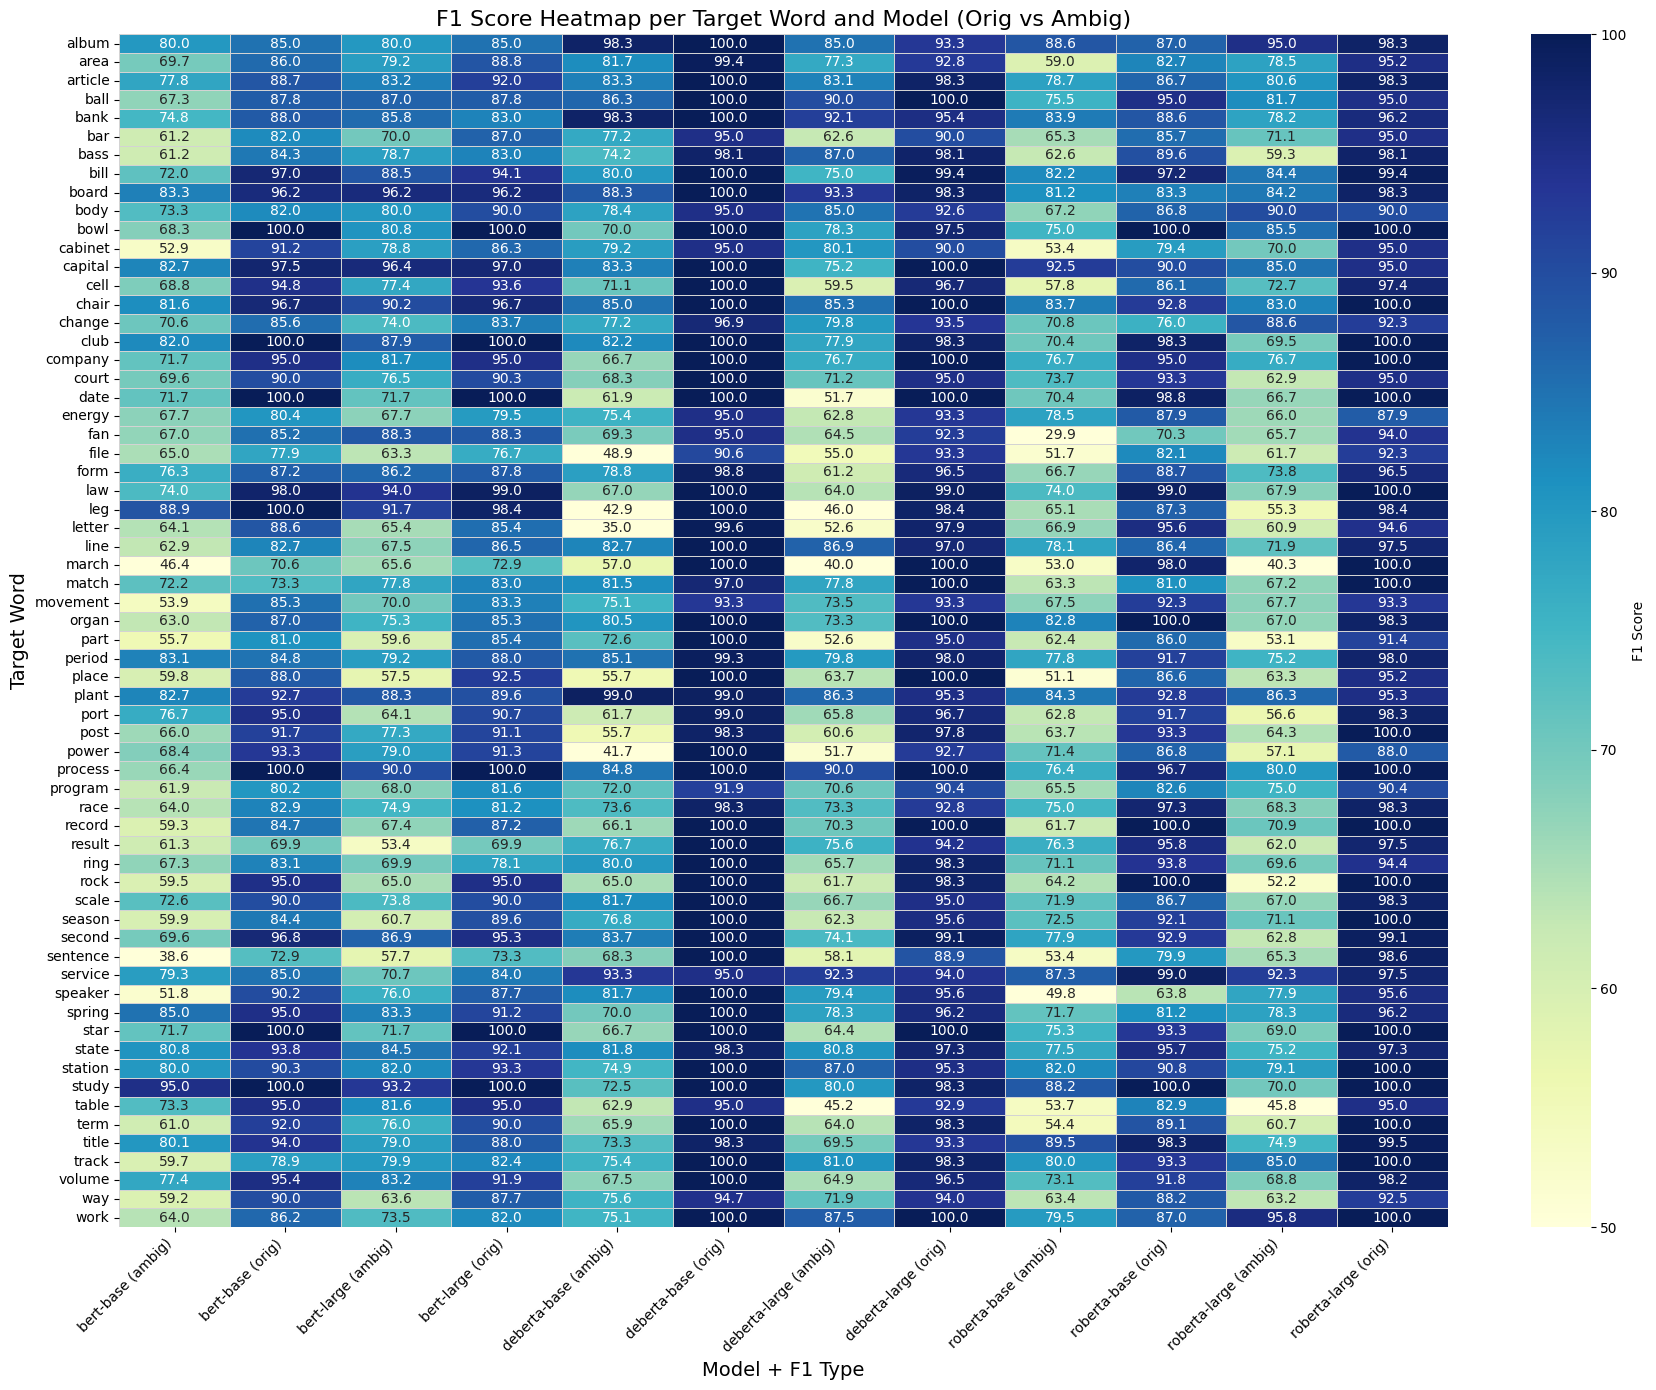

In [85]:
import seaborn as sns

melted = pd.melt(
    df_per_word,
    id_vars=["target_word", "model"],
    value_vars=["f1_orig", "f1_ambig"],
    var_name="f1_type",
    value_name="f1_score"
)

# Create combined column labels
melted["model_f1"] = melted["model"] + " (" + melted["f1_type"].str.replace("f1_", "") + ")"

# Pivot to wide format
pivot_df = melted.pivot(index="target_word", columns="model_f1", values="f1_score")


# Identify original and ambiguous F1 columns
orig_cols = [col for col in pivot_df.columns if "(orig)" in col]
ambig_cols = [col for col in pivot_df.columns if "(ambig)" in col]

# Compute per-word stats
pivot_df["mean_f1_orig"] = pivot_df[orig_cols].mean(axis=1)
pivot_df["std_f1_orig"] = pivot_df[orig_cols].std(axis=1)
pivot_df["mean_f1_ambig"] = pivot_df[ambig_cols].mean(axis=1)
pivot_df["std_f1_ambig"] = pivot_df[ambig_cols].std(axis=1)

# Print Top 10 highest and lowest F1 and Std scores
print("\nTop 10 highest mean F1 (orig):")
print(pivot_df["mean_f1_orig"].sort_values(ascending=False).head(10))

print("\nTop 10 highest mean F1 (ambig):")
print(pivot_df["mean_f1_ambig"].sort_values(ascending=False).head(10))

print("\nTop 10 highest std F1 (orig):")
print(pivot_df["std_f1_orig"].sort_values(ascending=False).head(10))

print("\nTop 10 highest std F1 (ambig):")
print(pivot_df["std_f1_ambig"].sort_values(ascending=False).head(10))

print("\nTop 10 lowest mean F1 (orig):")
print(pivot_df["mean_f1_orig"].sort_values().head(10))

print("\nTop 10 lowest mean F1 (ambig):")
print(pivot_df["mean_f1_ambig"].sort_values().head(10))

print("\nTop 10 lowest std F1 (orig):")
print(pivot_df["std_f1_orig"].sort_values().head(10))

print("\nTop 10 lowest std F1 (ambig):")
print(pivot_df["std_f1_ambig"].sort_values().head(10))



# Plot the heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(
    pivot_df[[col for col in pivot_df.columns if '(' in col]],  # only F1 columns, not mean/std
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=0.6,
    linecolor='lightgray',
    cbar_kws={'label': 'F1 Score'},
    vmin=50,
    vmax=100
)

# Labels and formatting
plt.title("F1 Score Heatmap per Target Word and Model (Orig vs Ambig)", fontsize=16)
plt.xlabel("Model + F1 Type", fontsize=14)
plt.ylabel("Target Word", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save
plt.savefig("figures/heatmap_f1_orig_vs_ambig_per_model_3.png", dpi=300)
plt.show()


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>5. Scatterplot</b> 
</div>

- Plot the highest and the lowest mean and standard deviation of F1 score for original and ambiguous questions
- The data from the previous outputs (Top 10 ...) are the input for this plot.

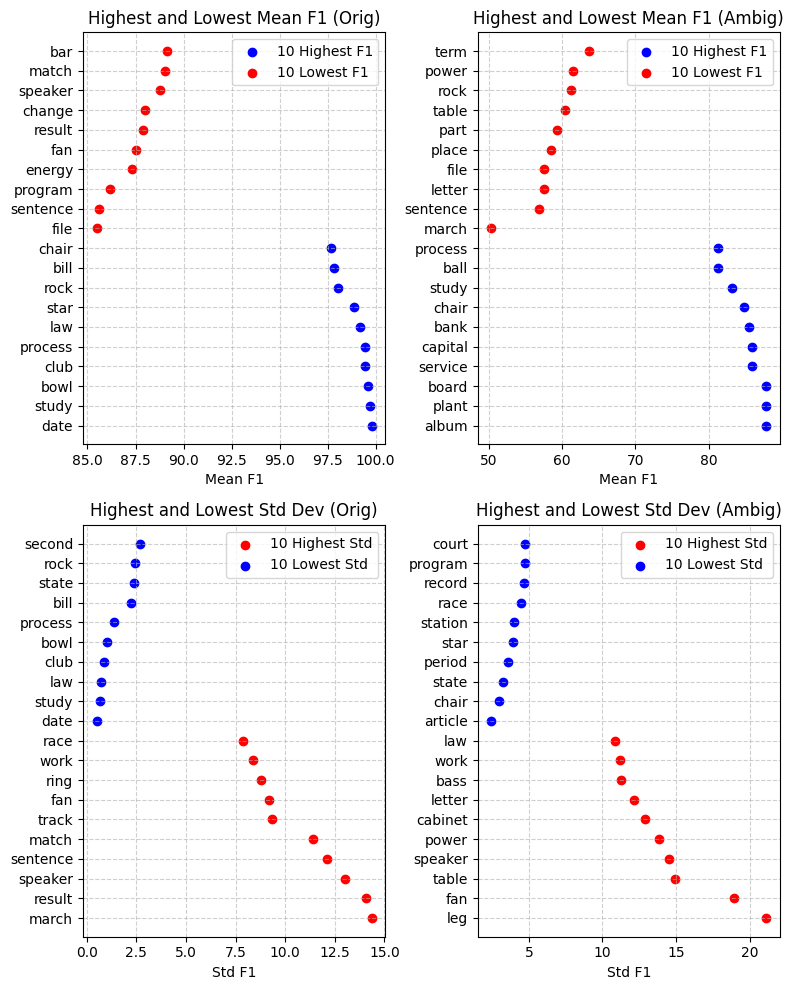

In [86]:
mean_f1_high_orig = {
    'date': 99.79, 'study': 99.72, 'bowl': 99.58, 'club': 99.44, 'process': 99.44,
    'law': 99.17, 'star': 98.89, 'rock': 98.06, 'bill': 97.86, 'chair': 97.69
}

mean_f1_low_orig = {
    'file': 85.48, 'sentence': 85.60, 'program': 86.18, 'energy': 87.33, 'fan': 87.53,
    'result': 87.87, 'change': 88.00, 'speaker': 88.79, 'match': 89.05, 'bar': 89.12
}

mean_f1_high_ambig = {
    'album': 87.82, 'plant': 87.82, 'board': 87.77, 'service': 85.88, 'capital': 85.87,
    'bank': 85.52, 'chair': 84.80, 'study': 83.14, 'ball': 81.29, 'process': 81.27
}

mean_f1_low_ambig = {
    'march': 50.38, 'sentence': 56.89, 'letter': 57.48, 'file': 57.59, 'place': 58.53,
    'part': 59.33, 'table': 60.43, 'rock': 61.27, 'power': 61.54, 'term': 63.68
}

std_f1_high_orig = {
    'march': 14.35, 'result': 14.08, 'speaker': 12.99, 'sentence': 12.11, 'match': 11.42,
    'track': 9.32, 'fan': 9.21, 'ring': 8.76, 'work': 8.36, 'race': 7.87
}

std_f1_low_orig = {
    'date': 0.51, 'study': 0.68, 'law': 0.75, 'club': 0.86, 'bowl': 1.02,
    'process': 1.36, 'bill': 2.24, 'state': 2.41, 'rock': 2.45, 'second': 2.71
}

std_f1_high_ambig = {
    'leg': 21.12, 'fan': 18.96, 'table': 14.92, 'speaker': 14.54, 'power': 13.87,
    'cabinet': 12.86, 'letter': 12.13, 'bass': 11.23, 'work': 11.18, 'law': 10.82
}

std_f1_low_ambig = {
    'article': 2.46, 'chair': 2.98, 'state': 3.28, 'period': 3.58, 'star': 3.92,
    'station': 4.00, 'race': 4.44, 'record': 4.65, 'program': 4.71, 'court': 4.71
}

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(8, 10))

# Top-left: Mean F1 (orig)
axs[0, 0].scatter(mean_f1_high_orig.values(), mean_f1_high_orig.keys(), color='blue', label='10 Highest F1')
axs[0, 0].scatter(mean_f1_low_orig.values(), mean_f1_low_orig.keys(), color='red', label='10 Lowest F1')
axs[0, 0].set_xlabel("Mean F1")
axs[0, 0].set_title("Highest and Lowest Mean F1 (Orig)")
axs[0, 0].legend()
axs[0, 0].grid(True, linestyle='--', alpha=0.6)

# Top-right: Mean F1 (ambig)
axs[0, 1].scatter(mean_f1_high_ambig.values(), mean_f1_high_ambig.keys(), color='blue', label='10 Highest F1')
axs[0, 1].scatter(mean_f1_low_ambig.values(), mean_f1_low_ambig.keys(), color='red', label='10 Lowest F1')
axs[0, 1].set_xlabel("Mean F1")
axs[0, 1].set_title("Highest and Lowest Mean F1 (Ambig)")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.6)

# Bottom-left: Std F1 (orig)
axs[1, 0].scatter(std_f1_high_orig.values(), std_f1_high_orig.keys(), color='red', label='10 Highest Std')
axs[1, 0].scatter(std_f1_low_orig.values(), std_f1_low_orig.keys(), color='blue', label='10 Lowest Std')
axs[1, 0].set_xlabel("Std F1")
axs[1, 0].set_title("Highest and Lowest Std Dev (Orig)")
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.6)

axs[1, 1].scatter(std_f1_high_ambig.values(), std_f1_high_ambig.keys(), color='red', label='10 Highest Std')
axs[1, 1].scatter(std_f1_low_ambig.values(), std_f1_low_ambig.keys(), color='blue', label='10 Lowest Std')
axs[1, 1].set_xlabel("Std F1")
axs[1, 1].set_title("Highest and Lowest Std Dev (Ambig)")
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.6)

# Save
plt.tight_layout()

plt.savefig("figures/f1_mean_std_comparison_plots_3.png", dpi=300)

plt.show()
